TODO

* [ ] Basic overview of data
* [ ] Compare training data with test data
* [ ] Determine proportion of fraud / not fraud in train set
* [ ] Explore distributions of values and missing values for most columns
* [ ] Determine information content of a few variables given label
* [ ] Compare distributions of variables for fraud versus not fraud in train
* [ ] Determine correlations of colums (pair-wise or more) with fraud
* [ ] Explore transaction amounts and their correlation with fraud
* [ ] Compare time delta between train and test set
* [ ] Types of credit cards, devices
* [ ] Explore product codes and their correlation with fraud
* [ ] Create a dictionary of columns (device type, type of card, credit card company, etc.)
* [ ] Try some techniques to rank feature importance
* [ ] Try to build some basic decision trees for individual, pairs, groups of features
* [ ] Try to build a manual model that applies heuristics to some column values to determine fraud based on your analysis
* [ ] Try computing z-scores on `TransactionAmt` and see if you can detect strong outliers
* [ ] Maybe turn this into a timeseries and see if you can detect anomalies
* [ ] Consider getting rid of columns that have largely NaN values

```python
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]
```

In [1]:
import sys
print(sys.executable)

/anaconda3/envs/py362scipy/bin/python


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/test_transaction.csv
data/train_identity.csv
data/datasource.txt
data/ieee-fraud-detection.zip
data/test_identity.csv
data/sample_submission.csv
data/train_transaction.csv


# Overview of data

In [3]:
input_path = "data"
train_identity = pd.read_csv(f"{input_path}/train_identity.csv")
train_transaction = pd.read_csv(f"{input_path}/train_transaction.csv")
test_identity = pd.read_csv(f"{input_path}/test_identity.csv")
test_transaction = pd.read_csv(f"{input_path}/test_transaction.csv")

In [5]:
train_identity.sample(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
8522,3017386,-5.0,9086.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,firefox 57.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,Windows
21508,3048869,-5.0,23596.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 63.0,24.0,1920x1200,match_status:2,T,F,T,T,desktop,Windows
40166,3084528,-5.0,103691.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 63.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
77157,3226734,-5.0,42548.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 63.0,24.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
144002,3576243,-5.0,332367.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,...,firefox,NaN,NaN,NaN,F,F,T,F,mobile,rv:60.0


Large number of anonymised column names. For many of the columns, it is not clear what data they represent. Some columns do make sense. For example:
* `id_31`: browser
* `id_33`: screen resolution
* `id_35` to `id_38` looks like a bunch of Booleans, but don't know what they represent.

Some values appear to be continuous-valued, others are categorical. Need to think whether there is a way to automatically estimate which columns represent continuous or categorical values (think about proportion of unique values per column). 

In [6]:
train_transaction.sample(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
11153,2998153,0,332610,100.00,W,11207,361.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
525958,3512958,0,13821782,160.50,W,16075,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53525,3040525,0,1266475,36.95,W,9680,111.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121897,3108897,0,2398714,34.00,W,15066,170.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569701,3556701,0,15111355,79.95,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Large number of `Vnnn` columns. What do the various `card` columns represent? 

In [7]:
train_identity.shape

(144233, 41)

In [8]:
train_transaction.shape

(590540, 394)

Approximately four times more rows in `train_transaction` than in `train_identity`.

In [9]:
train_identity.dtypes

TransactionID      int64
id_01            float64
id_02            float64
id_03            float64
id_04            float64
id_05            float64
id_06            float64
id_07            float64
id_08            float64
id_09            float64
id_10            float64
id_11            float64
id_12             object
id_13            float64
id_14            float64
id_15             object
id_16             object
id_17            float64
id_18            float64
id_19            float64
id_20            float64
id_21            float64
id_22            float64
id_23             object
id_24            float64
id_25            float64
id_26            float64
id_27             object
id_28             object
id_29             object
id_30             object
id_31             object
id_32            float64
id_33             object
id_34             object
id_35             object
id_36             object
id_37             object
id_38             object
DeviceType        object


In [10]:
train_transaction.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
                   ...   
V310              float64
V311              float64
V312              float64
V313              float64
V314              float64
V315              float64
V316              float64
V317        

Looks like the `V` columns in `train_transaction` are supposed to be numeric.

# Data exploration

In [11]:
train_identity.describe()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.077142e+06,-10.000000,67992.000000,0.000000,0.000000,0.000000,-6.000000,5.000000,-48.000000,0.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.198818e+06,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,14.000000,-34.000000,0.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.392923e+06,-5.000000,228749.000000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577534e+06,0.000000,999595.000000,10.000000,0.000000,52.000000,0.000000,61.000000,0.000000,25.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


`id_01` has only negative values and 0. Interesting.

In [13]:
train_transaction.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


The `TransactionAmt` column is obviously quite interesting. Has large standard deviation and mean and median are not close together. Let's look at the distribution of transaction amounts.

(0, 600)

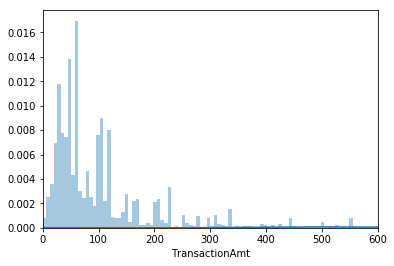

In [31]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.distplot(train_transaction["TransactionAmt"], kde=True, bins=5000, ax=ax)
plt.xlim(0, 600)

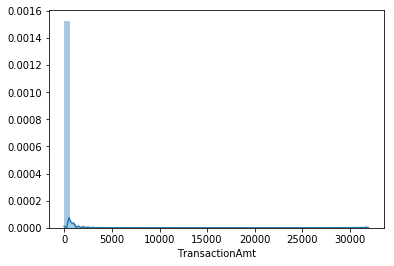

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.distplot(train_transaction["TransactionAmt"], kde=True, ax=ax)

In [36]:
train_identity.isnull().sum()

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
id_10             69307
id_11              3255
id_12                 0
id_13             16913
id_14             64189
id_15              3248
id_16             14893
id_17              4864
id_18             99120
id_19              4915
id_20              4972
id_21            139074
id_22            139064
id_23            139064
id_24            139486
id_25            139101
id_26            139070
id_27            139064
id_28              3255
id_29              3255
id_30             66668
id_31              3951
id_32             66647
id_33             70944
id_34             66428
id_35              3248
id_36              3248
id_37              3248
id_38              3248
DeviceType         3423
DeviceInfo        25567
dtype: int64

In [37]:
train_transaction.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
                   ...  
V310                  12
V311                  12
V312                  12
V313                1269
V314                1269
V315                1269
V316                  12
V317                  12
V318                  12


* A lot of missing column values. 
* A lot of anonymised column names, but can make out meaning according to values in some cases.

**TODO:** Should consider renaming columns we can make sense of. 

## Proportion of fraudulent transactions

In [38]:
num_txs = len(train_transaction.index)
num_fraud = train_transaction[train_transaction.isFraud == True].count()["TransactionID"]
print(f"The proportion of fraudulent transactions in the training set is {(num_fraud / num_txs) * 100:.3f}%")

The proportion of fraudulent transactions in the training set is 3.499%


/anaconda3/envs/py362scipy/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 1000)

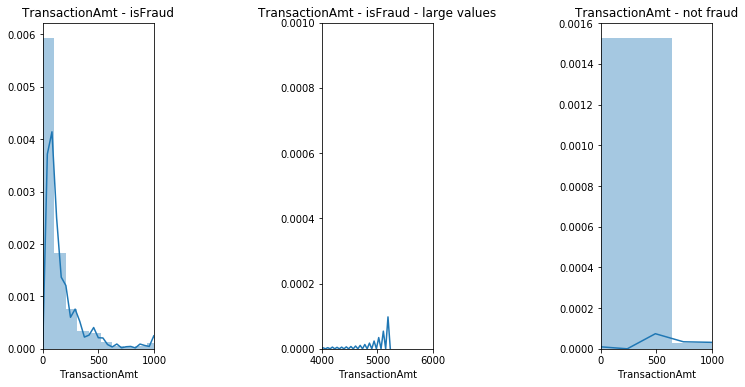

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
ax1, ax2, ax3 = axes.flatten()
plt.subplots_adjust(wspace=1.5)

tx_amt_fraud = train_transaction.loc[train_transaction.isFraud == True]
sns.distplot(tx_amt_fraud["TransactionAmt"], kde=True, ax=ax1)
ax1.set_title("TransactionAmt - isFraud")
ax1.set_xlim(0, 1000)

tx_amt_fraud = train_transaction.loc[train_transaction.isFraud == True]
sns.distplot(tx_amt_fraud["TransactionAmt"], kde=True, ax=ax2)
ax2.set_title("TransactionAmt - isFraud - large values")
ax2.set_xlim(4000, 6000)
ax2.set_ylim(0, 0.001)

tx_amt_not_fraud = train_transaction.loc[train_transaction.isFraud == False]
sns.distplot(tx_amt_not_fraud["TransactionAmt"], kde=True, ax=ax3)
ax3.set_title("TransactionAmt - not fraud")
ax3.set_xlim(0, 1000)

In [73]:
tx_amt_fraud["TransactionAmt"].describe()

count    20663.000000
mean       149.244779
std        232.212163
min          0.292000
25%         35.044000
50%         75.000000
75%        161.000000
max       5191.000000
Name: TransactionAmt, dtype: float64

In [74]:
tx_amt_not_fraud["TransactionAmt"].describe()

count    569877.000000
mean        134.511665
std         239.395078
min           0.251000
25%          43.970000
50%          68.500000
75%         120.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

# Distributions

## id columns

In [40]:
train_identity["id_01"].value_counts(ascending=False, dropna=False, normalize=True).head(10)

-5.0      0.569703
 0.0      0.135579
-10.0     0.078047
-20.0     0.077728
-15.0     0.039339
-25.0     0.032052
-45.0     0.014858
-35.0     0.011246
-40.0     0.009603
-100.0    0.007016
Name: id_01, dtype: float64

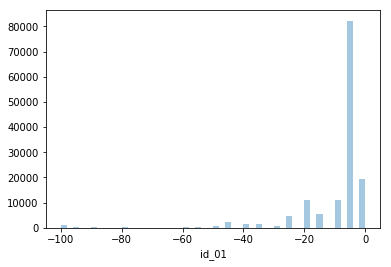

In [78]:
sns.distplot(train_identity["id_01"], kde=False)

id_01:
 -5.0      0.569703
 0.0      0.135579
-10.0     0.078047
-20.0     0.077728
-15.0     0.039339
-25.0     0.032052
-45.0     0.014858
-35.0     0.011246
-40.0     0.009603
-100.0    0.007016
Name: id_01, dtype: float64

id_02:
 NaN        0.023303
 1102.0    0.000076
 696.0     0.000069
 1116.0    0.000062
 1117.0    0.000062
 1141.0    0.000062
 1083.0    0.000062
 1120.0    0.000062
 1127.0    0.000055
 1119.0    0.000049
Name: id_02, dtype: float64

id_03:
 NaN     0.540161
 0.0    0.443054
 1.0    0.005983
 3.0    0.004631
 2.0    0.002919
 5.0    0.000756
 4.0    0.000693
 6.0    0.000444
-5.0    0.000229
-6.0    0.000215
Name: id_03, dtype: float64

id_04:
 NaN      0.540161
 0.0     0.455783
-5.0     0.000915
-6.0     0.000679
-8.0     0.000444
-4.0     0.000354
-1.0     0.000298
-11.0    0.000243
-12.0    0.000236
-10.0    0.000208
Name: id_04, dtype: float64

id_05:
  0.0    0.643008
 1.0    0.057497
NaN     0.051084
 2.0    0.034229
 3.0    0.026721
 4.0    0.020391
 6

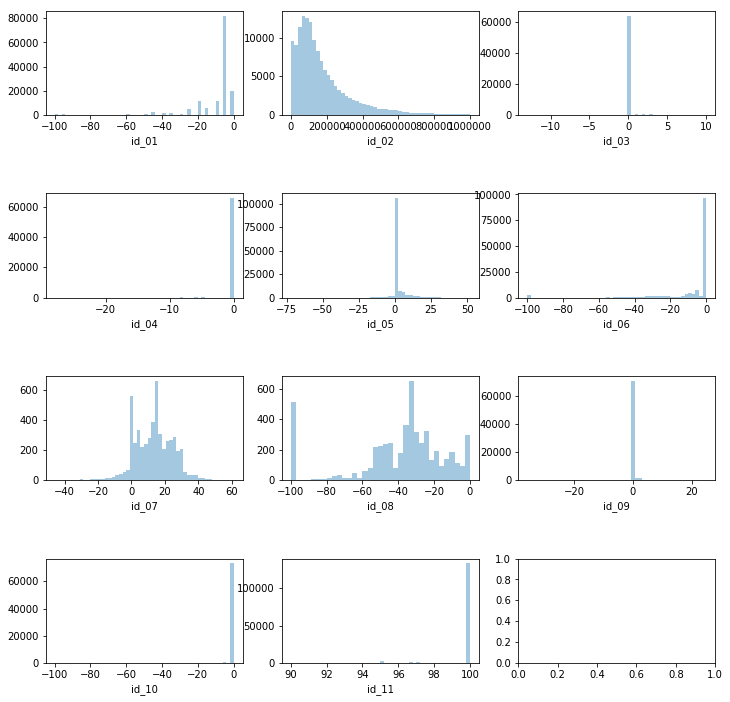

In [111]:
id_cols = ["id_01", "id_02", "id_03", "id_04", "id_05", "id_06", "id_07", "id_08", "id_09", "id_10", "id_11",
       "id_12", "id_13", "id_14", "id_15", "id_16", "id_17", "id_18", "id_19", "id_20", "id_21", "id_22",
       "id_23", "id_24", "id_25", "id_26", "id_27", "id_28", "id_29", "id_30", "id_31", "id_32", "id_33",
       "id_34", "id_35", "id_36", "id_37", "id_38"]

cat_id_cols = ["id_12", "id_13", "id_14", "id_15", "id_16", "id_17", "id_18", "id_19", "id_20", "id_21", "id_22",
       "id_23", "id_24", "id_25", "id_26", "id_27", "id_28", "id_29", "id_30", "id_31", "id_32", "id_33",
       "id_34", "id_35", "id_36", "id_37", "id_38"]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
plt.subplots_adjust(hspace=0.75)

row_idx = 0
col_idx = 0
for col in id_cols:
    try:
        print(f"{col}:\n {train_identity[col].value_counts(ascending=False, dropna=False, normalize=True).head(10)}\n")
        if col not in cat_id_cols:
            sns.distplot(train_identity[col].dropna(), kde=False, ax=axes[row_idx][col_idx], label=col)
        if col_idx == 2:
            row_idx += 1
        if col_idx == 0:
            col_idx = 1
        elif col_idx == 1:
            col_idx = 2
        else:
            col_idx = 0
    except TypeError as err:
        print(f"Caught error for col: {col} due to {err}\n")
        print(f"sample: {train_identity[col].sample()}\n")

*TODO:* Go over categories of variables and try to understand them a bit better. Follow this example [notebook](https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda).

id_12:
NotFound    0.85296
Found       0.14704
Name: id_12, dtype: float64

id_13:
 52.0    0.402814
 49.0    0.182795
NaN      0.117262
 64.0    0.100040
 33.0    0.069665
 27.0    0.025417
 20.0    0.019954
 14.0    0.017326
 63.0    0.010178
 19.0    0.007952
Name: id_13, dtype: float64



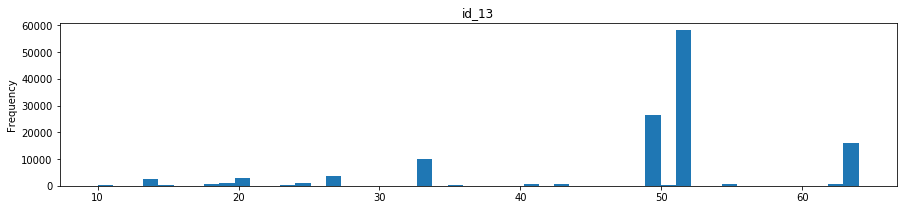

id_14:
NaN       0.445037
-300.0    0.305901
-360.0    0.115514
-480.0    0.089376
-420.0    0.031491
-600.0    0.003453
 60.0     0.002558
 0.0      0.001331
-240.0    0.001102
-180.0    0.000874
Name: id_14, dtype: float64



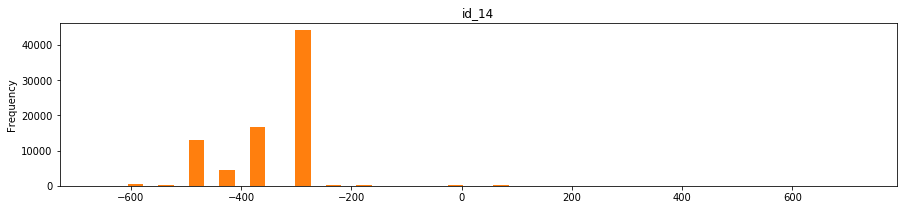

id_15:
Found      0.469574
New        0.427170
Unknown    0.080737
NaN        0.022519
Name: id_15, dtype: float64

id_16:
Found       0.459839
NotFound    0.436904
NaN         0.103257
Name: id_16, dtype: float64

id_17:
 166.0    0.545167
 225.0    0.394972
NaN       0.033723
 102.0    0.004777
 159.0    0.002440
 100.0    0.002330
 121.0    0.001934
 148.0    0.001588
 150.0    0.000874
 191.0    0.000853
Name: id_17, dtype: float64



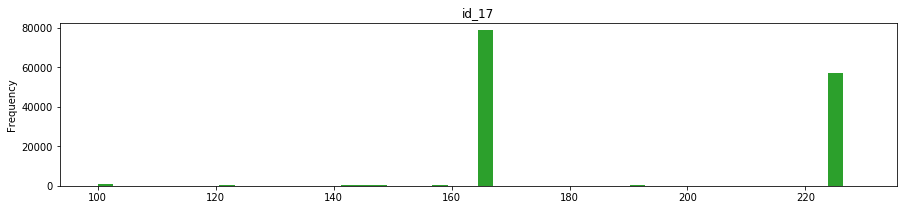

id_18:
NaN      0.687221
 15.0    0.176721
 13.0    0.093176
 12.0    0.032281
 18.0    0.004507
 20.0    0.002350
 17.0    0.001615
 26.0    0.000617
 21.0    0.000541
 24.0    0.000361
Name: id_18, dtype: float64



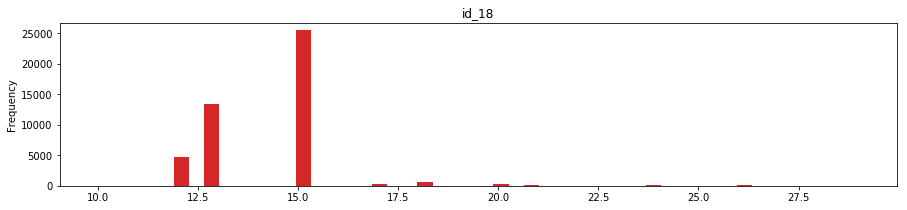

id_19:
 266.0    0.137618
 410.0    0.078470
 427.0    0.061068
 529.0    0.056312
 312.0    0.043173
 100.0    0.036483
 542.0    0.035470
NaN       0.034077
 215.0    0.032780
 153.0    0.030395
Name: id_19, dtype: float64



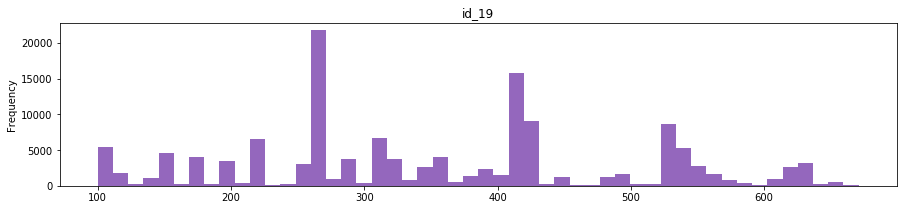

id_20:
 507.0    0.154687
 222.0    0.076716
 325.0    0.056388
 533.0    0.045836
 214.0    0.039270
 549.0    0.039124
 600.0    0.038570
NaN       0.034472
 563.0    0.032662
 333.0    0.025591
Name: id_20, dtype: float64



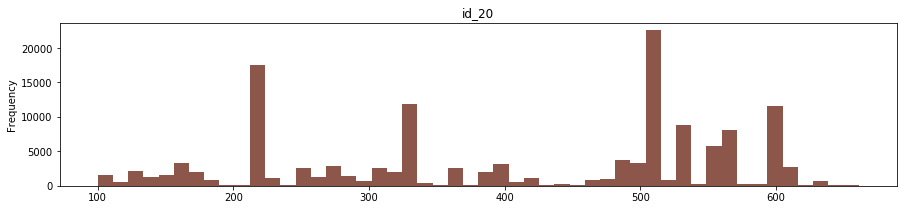

id_21:
NaN       0.964231
 252.0    0.017624
 228.0    0.001657
 255.0    0.000756
 596.0    0.000714
 576.0    0.000700
 849.0    0.000610
 277.0    0.000596
 755.0    0.000451
 848.0    0.000402
Name: id_21, dtype: float64



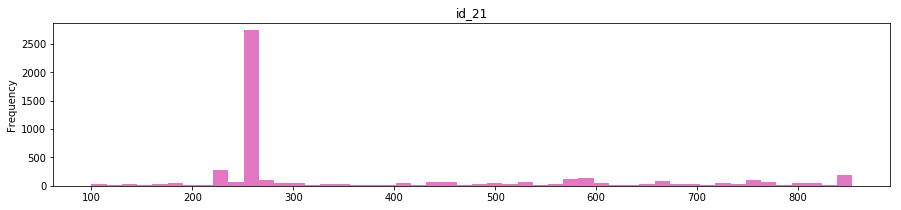

id_22:
NaN      0.964162
 14.0    0.032836
 41.0    0.002226
 33.0    0.000263
 21.0    0.000049
 17.0    0.000049
 39.0    0.000042
 12.0    0.000035
 31.0    0.000035
 22.0    0.000035
Name: id_22, dtype: float64



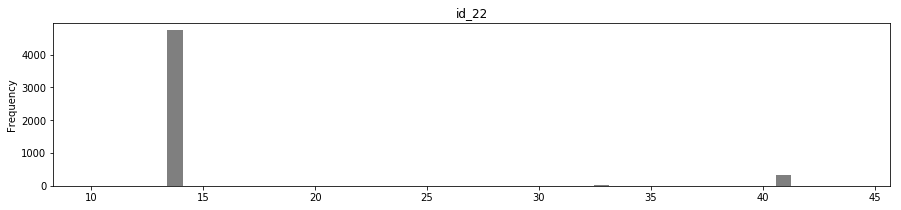

id_23:
NaN                     0.964162
IP_PROXY:TRANSPARENT    0.024190
IP_PROXY:ANONYMOUS      0.007425
IP_PROXY:HIDDEN         0.004222
Name: id_23, dtype: float64

id_24:
NaN      0.967088
 11.0    0.019531
 15.0    0.011052
 16.0    0.001525
 18.0    0.000257
 21.0    0.000229
 24.0    0.000083
 17.0    0.000062
 26.0    0.000055
 25.0    0.000049
Name: id_24, dtype: float64



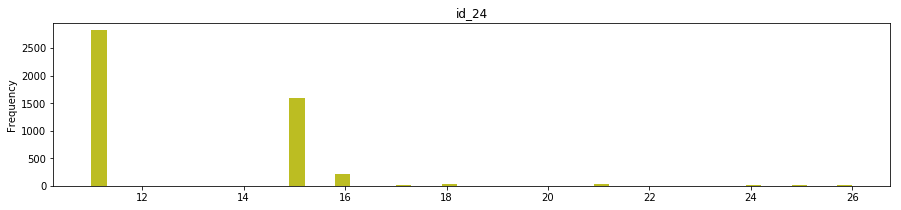

id_25:
NaN       0.964419
 321.0    0.017291
 205.0    0.002087
 426.0    0.001636
 501.0    0.000714
 371.0    0.000575
 524.0    0.000541
 442.0    0.000534
 509.0    0.000451
 123.0    0.000367
Name: id_25, dtype: float64



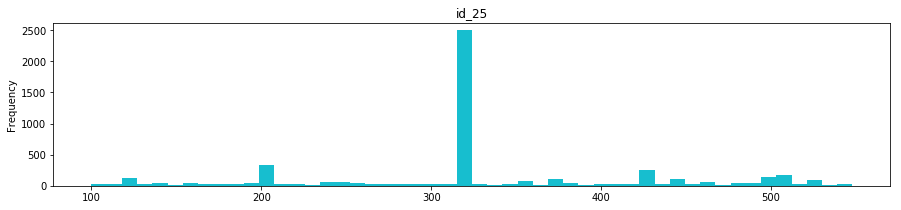

id_26:
NaN       0.964204
 161.0    0.005713
 184.0    0.004035
 142.0    0.003661
 102.0    0.003127
 100.0    0.003002
 119.0    0.002600
 169.0    0.002531
 147.0    0.001615
 215.0    0.000985
Name: id_26, dtype: float64



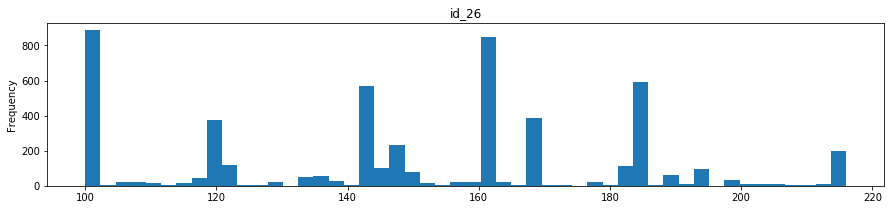

id_27:
NaN         0.964162
Found       0.035741
NotFound    0.000097
Name: id_27, dtype: float64

id_28:
Found    0.528534
New      0.448899
NaN      0.022568
Name: id_28, dtype: float64

id_29:
Found       0.519479
NotFound    0.457953
NaN         0.022568
Name: id_29, dtype: float64

id_30:
NaN                 0.462224
Windows 10          0.146672
Windows 7           0.090895
iOS 11.2.1          0.025805
iOS 11.1.2          0.025646
Android 7.0         0.019905
Mac OS X 10_12_6    0.017742
Mac OS X 10_11_6    0.016279
iOS 11.3.0          0.013977
Windows 8.1         0.013270
Name: id_30, dtype: float64

id_31:
chrome 63.0                0.152531
mobile safari 11.0         0.093065
mobile safari generic      0.079552
ie 11.0 for desktop        0.062607
safari generic             0.056818
chrome 62.0                0.049794
chrome 65.0                0.047638
chrome 64.0                0.046529
chrome 63.0 for android    0.040254
chrome generic             0.033127
Name: id_31, dtype:

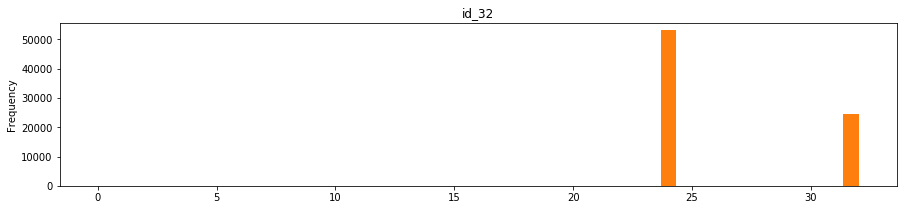

id_33:
NaN          0.491871
1920x1080    0.116991
1366x768     0.059660
1334x750     0.044699
2208x1242    0.033973
1440x900     0.030395
1600x900     0.024336
2048x1536    0.024141
1280x800     0.014900
2560x1600    0.014511
Name: id_33, dtype: float64

id_34:
NaN                0.460560
match_status:2     0.416070
match_status:1     0.120472
match_status:0     0.002877
match_status:-1    0.000021
Name: id_34, dtype: float64

id_35:
T      0.539502
F      0.437979
NaN    0.022519
Name: id_35, dtype: float64

id_36:
F      0.929510
T      0.047971
NaN    0.022519
Name: id_36, dtype: float64

id_37:
T      0.765789
F      0.211692
NaN    0.022519
Name: id_37, dtype: float64

id_38:
F      0.512518
T      0.464963
NaN    0.022519
Name: id_38, dtype: float64



In [131]:
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
    
color_idx = 0
for col in cat_id_cols:
    print(f"{col}:\n{train_identity[col].value_counts(ascending=False, dropna=False, normalize=True).head(10)}\n")
    if train_identity[col].dtype in ["float64", "int64"]:
        train_identity[col].plot(kind="hist",
                                title=col,
                                bins=50,
                                figsize=(15, 3),
                                color=color_pal[color_idx])
        color_idx += 1
        if color_idx == len(plt.rcParams["axes.prop_cycle"]):
            color_idx = 0
        plt.show()


# card columns

In [132]:
card_cols = [c for c in train_transaction.columns if 'card' in c]
train_transaction[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


card1:
7919     0.025285
9500     0.023981
15885    0.017545
17188    0.017516
15066    0.013454
12695    0.012008
12544    0.011469
6019     0.011466
2803     0.010399
7585     0.009032
Name: card1, dtype: float64



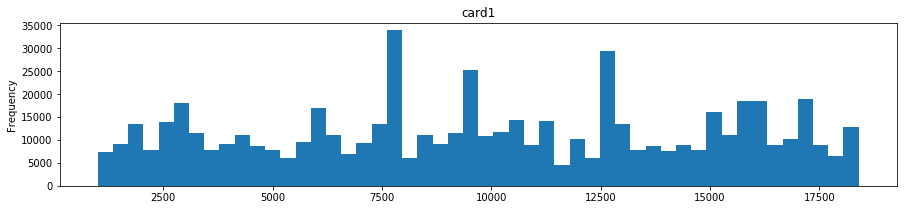

card2:
321.0    0.082865
111.0    0.076525
555.0    0.071113
490.0    0.064593
583.0    0.036920
170.0    0.030843
194.0    0.028682
545.0    0.027695
360.0    0.025722
514.0    0.024623
Name: card2, dtype: float64



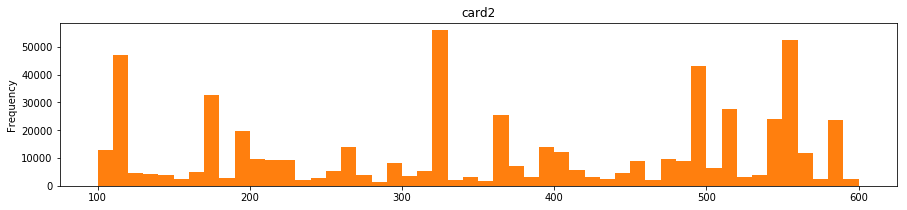

card3:
 150.0    0.882729
 185.0    0.095414
 106.0    0.002660
NaN       0.002650
 146.0    0.002120
 144.0    0.002120
 117.0    0.001629
 143.0    0.001522
 119.0    0.001270
 102.0    0.000779
Name: card3, dtype: float64



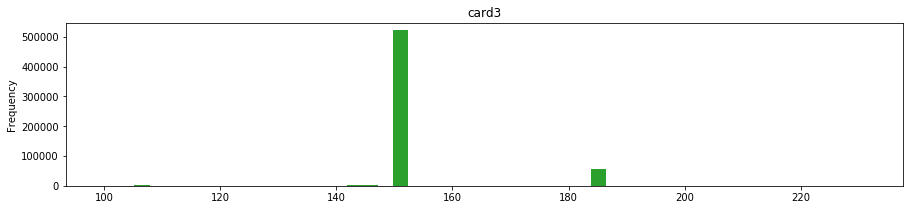

card4:
visa                0.651551
mastercard          0.320414
american express    0.014102
discover            0.011263
NaN                 0.002670
Name: card4, dtype: float64

card5:
226.0    0.502161
224.0    0.138031
166.0    0.096759
102.0    0.049285
117.0    0.043928
138.0    0.033422
195.0    0.028694
137.0    0.019846
126.0    0.017438
219.0    0.016805
Name: card5, dtype: float64



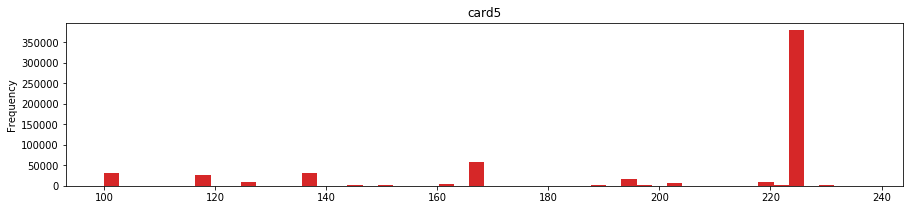

card6:
debit              0.744976
credit             0.252288
NaN                0.002660
debit or credit    0.000051
charge card        0.000025
Name: card6, dtype: float64



In [134]:
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
    
color_idx = 0
for col in card_cols:
    print(f"{col}:\n{train_transaction[col].value_counts(ascending=False, dropna=False, normalize=True).head(10)}\n")
    if train_transaction[col].dtype in ["float64", "int64"]:
        train_transaction[col].plot(kind="hist",
                                title=col,
                                bins=50,
                                figsize=(15, 3),
                                color=color_pal[color_idx])
        color_idx += 1
        if color_idx == len(plt.rcParams["axes.prop_cycle"]):
            color_idx = 0
        plt.show()


In [168]:
print("Proportion of fraudulent transactions by credit card company (card4)")
mean_fraud_card4 = train_transaction.groupby("card4")["isFraud"].mean()
mean_fraud_card4

Proportion of fraudulent transactions by credit card company (card4)


card4
american express    0.028698
discover            0.077282
mastercard          0.034331
visa                0.034756
Name: isFraud, dtype: float64

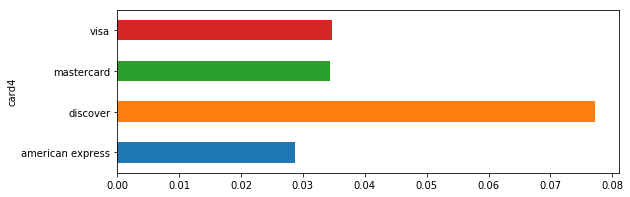

In [169]:
mean_fraud_card4.plot(kind="barh", figsize=(9, 3))

In [170]:
print("Proportion of fraudulent transactions by payment card type (card6)")
mean_fraud_card6 = train_transaction.groupby("card6")["isFraud"].mean()
mean_fraud_card6

Proportion of fraudulent transactions by payment card type (card6)


card6
charge card        0.000000
credit             0.066785
debit              0.024263
debit or credit    0.000000
Name: isFraud, dtype: float64

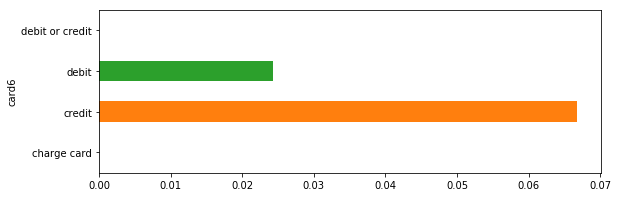

In [171]:
mean_fraud_card6.plot(kind="barh", figsize=(9, 3))

## ProductCD column

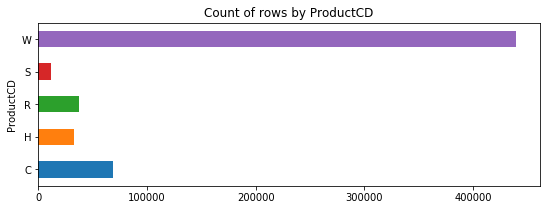

In [154]:
train_transaction.groupby("ProductCD")["TransactionID"].count().plot(
    kind="barh", 
    title="Count of rows by ProductCD", 
    figsize=(9, 3))

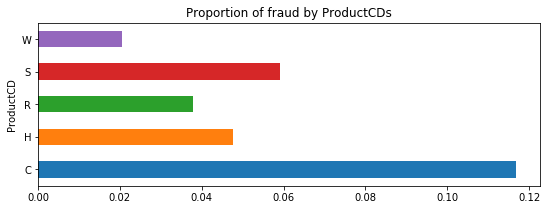

In [157]:
train_transaction.groupby("ProductCD")["isFraud"].mean().plot(
    kind="barh", 
    title="Proportion of fraud by ProductCDs",
    figsize=(9, 3))

## addr columns

In [12]:
train_transaction["addr1"].sample(5)

294600      NaN
236027    299.0
311806    264.0
381763    337.0
202238    325.0
Name: addr1, dtype: float64

In [13]:
train_transaction["addr2"].sample(5)

215965     NaN
415351    87.0
567221    87.0
435154    87.0
502038    87.0
Name: addr2, dtype: float64

In [9]:
train_transaction["addr1"].describe()

count    524834.000000
mean        290.733794
std         101.741072
min         100.000000
25%         204.000000
50%         299.000000
75%         330.000000
max         540.000000
Name: addr1, dtype: float64

In [10]:
train_transaction["addr2"].describe()

count    524834.000000
mean         86.800630
std           2.690623
min          10.000000
25%          87.000000
50%          87.000000
75%          87.000000
max         102.000000
Name: addr2, dtype: float64

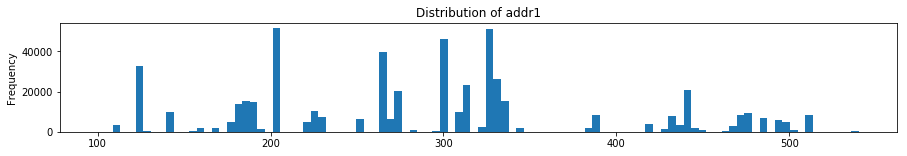

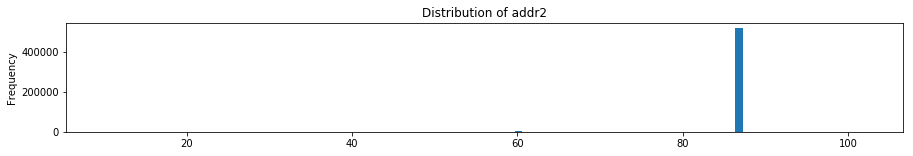

In [7]:
train_transaction["addr1"].plot(kind="hist", bins=100, figsize=(15, 2), title="Distribution of addr1")
plt.show()
train_transaction["addr2"].plot(kind="hist", bins=100, figsize=(15, 2), title="Distribution of addr2")
plt.show()

How do these values make sense of address fields? Not textual, not categorical, and `addr2` has a lot contains a lot of the same value. 

# dist columns

dist1:
NaN     0.596524
 0.0    0.033569
 1.0    0.031039
 2.0    0.028835
 4.0    0.022127
 3.0    0.021689
 5.0    0.020327
 6.0    0.016668
 7.0    0.015816
 8.0    0.013091
Name: dist1, dtype: float64



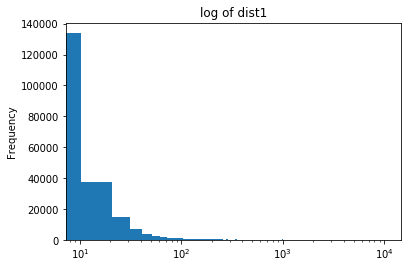

In [25]:
print(f"dist1:\n{train_transaction['dist1'].value_counts(ascending=False, dropna=False, normalize=True).head(10)}\n")
train_transaction["dist1"].plot(kind="hist", bins=1000, logx=True, title="log of dist1")

dist1 for isFraud: NaN     0.769879
 1.0    0.024779
 0.0    0.018390
 5.0    0.012922
 4.0    0.010405
 2.0    0.009679
 3.0    0.007259
 9.0    0.007066
 6.0    0.006969
 7.0    0.006630
Name: dist1, dtype: float64



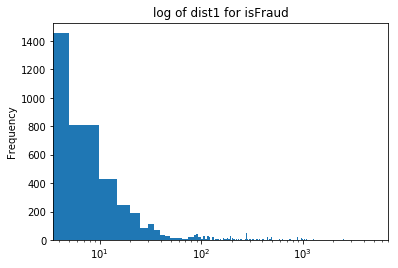

In [28]:
print(f"dist1 for isFraud: {train_transaction[train_transaction['isFraud'] == True]['dist1'].value_counts(ascending=False, dropna=False, normalize=True).head(10)}\n")
train_transaction[train_transaction["isFraud"] == True]["dist1"].plot(
    kind="hist", 
    bins=1000, 
    logx=True, 
    title="log of dist1 for isFraud")

dist2:
NaN      0.936284
 7.0     0.009630
 0.0     0.005959
 1.0     0.002327
 9.0     0.001256
 4.0     0.001116
 2.0     0.000942
 3.0     0.000830
 68.0    0.000821
 6.0     0.000698
Name: dist2, dtype: float64



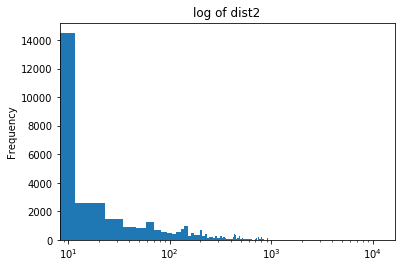

In [29]:
print(f"dist2:\n{train_transaction['dist2'].value_counts(ascending=False, dropna=False, normalize=True).head(10)}\n")
train_transaction["dist2"].plot(kind="hist", bins=1000, logx=True, title="log of dist2")

dist2 for isFraud: NaN       0.819436
 0.0      0.026134
 7.0      0.024004
 1.0      0.009292
 9.0      0.005324
 17.0     0.003436
 199.0    0.003388
 49.0     0.002710
 478.0    0.002662
 150.0    0.002468
Name: dist2, dtype: float64



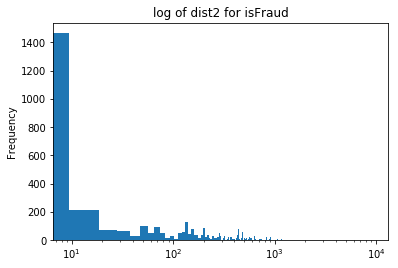

In [30]:
print(f"dist2 for isFraud: {train_transaction[train_transaction['isFraud'] == True]['dist2'].value_counts(ascending=False, dropna=False, normalize=True).head(10)}\n")
train_transaction[train_transaction["isFraud"] == True]["dist2"].plot(
    kind="hist", 
    bins=1000, 
    logx=True, 
    title="log of dist2 for isFraud")

## M columns

In [42]:
m_cols = [c for c in train_transaction if c.startswith("M")]
train_transaction[m_cols].sample(10)

,M1,M2,M3,M4,M5,M6,M7,M8,M9
418947,T,T,F,NaN,NaN,NaN,NaN,NaN,NaN
539378,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
104731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276621,T,F,F,M1,F,T,F,F,T
562806,T,T,T,NaN,NaN,F,F,F,T
268788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309653,NaN,NaN,NaN,M1,F,T,NaN,NaN,NaN
235515,NaN,NaN,NaN,M0,F,F,NaN,NaN,NaN
277534,T,T,T,M0,T,F,F,T,T
484001,T,F,F,M0,T,F,T,F,T


In [34]:
train_transaction[m_cols].describe()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,319440,319440,319440,309096,240058,421180,244275,244288,244288
unique,2,2,2,3,2,2,2,2,2
top,T,T,T,M0,F,F,F,F,T
freq,319415,285468,251731,196405,132491,227856,211374,155251,205656


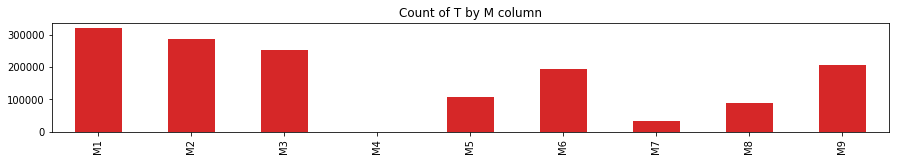

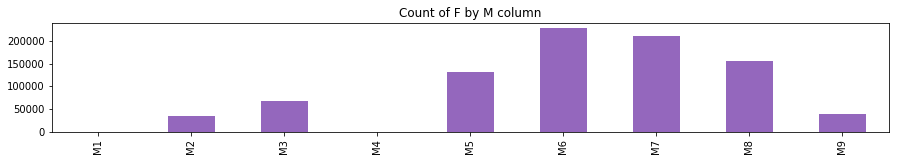

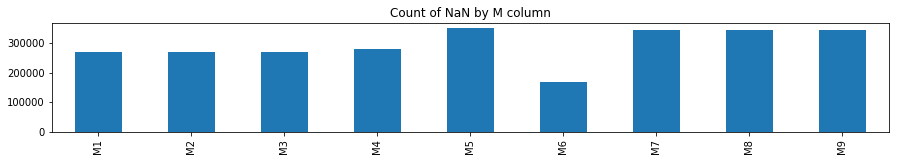

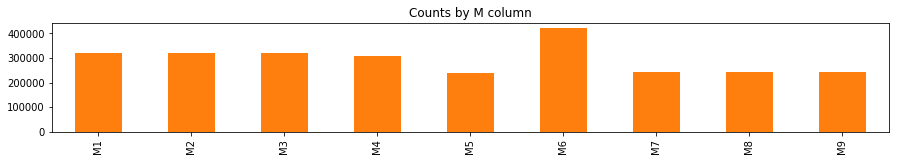

In [49]:
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

(train_transaction[m_cols] == 'T').sum().plot(kind='bar',
                                              title='Count of T by M column',
                                              figsize=(15, 2),
                                              color=color_pal[3])
plt.show()
(train_transaction[m_cols] == 'F').sum().plot(kind='bar',
                                              title='Count of F by M column',
                                              figsize=(15, 2),
                                              color=color_pal[4])
plt.show()
(train_transaction[m_cols].isna()).sum().plot(kind='bar',
                                              title='Count of NaN by M column',
                                              figsize=(15, 2),
                                              color=color_pal[0])
plt.show()
(train_transaction[m_cols]).count().plot(kind="bar",
                                         title="Counts by M column",
                                         figsize=(15, 2),
                                         color=color_pal[1])

`M4` does not have `F` or `T` as its values.

In [56]:
#train_transaction.groupby("M4").count()
train_transaction["M4"].value_counts()

M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64

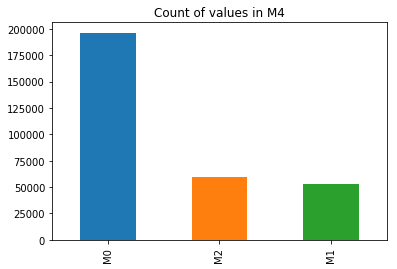

In [58]:
train_transaction["M4"].value_counts().plot(kind="bar",
                                            title="Count of values in M4")

## C columns

In [35]:
c_cols = [c for c in train_transaction if c.startswith("C")]
train_transaction[c_cols].sample(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
103552,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
325254,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
322449,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
309233,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0
549930,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,13.0,2.0


In [36]:
train_transaction[c_cols].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215
std,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,1.000000
75%,3.000000,3.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,12.000000,2.000000
max,4685.000000,5691.000000,26.000000,2253.000000,349.000000,2253.000000,2255.000000,3331.000000,210.000000,3257.000000,3188.000000,3188.000000,2918.000000,1429.000000


## DeviceType

In [61]:
train_identity.groupby("DeviceType")["TransactionID"].count()

DeviceType
desktop    85165
mobile     55645
Name: TransactionID, dtype: int64

In [65]:
train_identity_wFraud = train_identity.merge(
    train_transaction[["TransactionID", "TransactionAmt", "isFraud"]],
                        on=['TransactionID'])
train_identity_wFraud.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt,isFraud
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,50.000,0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,15.000,0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,F,F,T,T,desktop,Windows,75.887,0
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,F,F,T,T,desktop,NaN,16.495,0
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,1280x800,match_status:2,T,F,T,T,desktop,MacOS,30.000,0


In [74]:
device_types_fraud = train_identity_wFraud[train_identity_wFraud["isFraud"] == 1][["DeviceType", "isFraud", "TransactionAmt"]]
device_types_fraud.head()

,DeviceType,isFraud,TransactionAmt
52,mobile,1,37.098
53,mobile,1,37.098
54,mobile,1,37.098
69,mobile,1,155.521
86,desktop,1,225.000


In [75]:
device_types_notFraud = train_identity_wFraud[train_identity_wFraud["isFraud"] == 0][["DeviceType", "isFraud", "TransactionAmt"]]
device_types_notFraud.head()

,DeviceType,isFraud,TransactionAmt
0,mobile,0,50.000
1,mobile,0,15.000
2,desktop,0,75.887
3,desktop,0,16.495
4,desktop,0,30.000


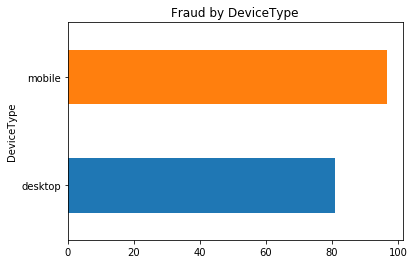

In [90]:
device_types_fraud.groupby("DeviceType")["TransactionAmt"].mean().sort_values().plot(
        kind="barh",
        title="Fraud by DeviceType")

In [93]:
device_types_fraud["TransactionAmt"].mean()

88.81034157978442

Proportion of TransactionAmt for isFraud:
100.0    0.127315
50.0     0.102834
150.0    0.054842
25.0     0.045849
200.0    0.041579
75.0     0.031359
250.0    0.019711
30.0     0.017645
125.0    0.015135
300.0    0.014289
Name: TransactionAmt, dtype: float64



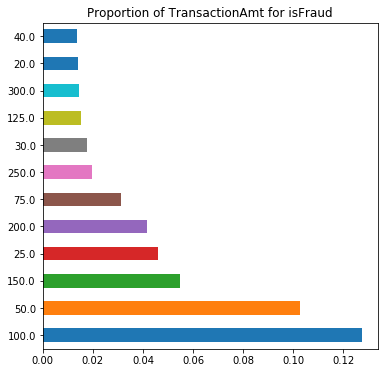

In [121]:
print(f"Proportion of TransactionAmt for isFraud:\n{train_identity_wFraud['TransactionAmt'].value_counts(ascending=False, dropna=False, normalize=True).head(10)}\n")
train_identity_wFraud['TransactionAmt'].value_counts(ascending=False, dropna=False, normalize=True).head(12).plot(
    kind="barh",
    figsize=(6, 6),
    title="Proportion of TransactionAmt for isFraud")

# Correlations and information content

In [137]:
tx_correlations = train_transaction.corr().head()

In [139]:
tx_correlations[(tx_correlations > 0.7).any(axis=1) | (tx_correlations < -0.7).any(axis=1)]

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,1.000000,0.014166,0.998280,0.012025,0.010122,-0.019900,-0.010091,-0.023900,-0.000370,0.057213,...,0.250831,0.199285,0.219190,0.223816,0.005893,0.179740,0.103030,0.074034,0.203922,0.162702
isFraud,0.014166,1.000000,0.013103,0.011320,-0.013640,0.003388,0.154151,-0.033580,0.005596,-0.030387,...,-0.021164,-0.021982,-0.023468,-0.024134,-0.000451,-0.005456,-0.002402,-0.005702,-0.019356,-0.014663
TransactionDT,0.998280,0.013103,1.000000,0.011920,0.010625,-0.019202,-0.011222,-0.024132,-0.000051,0.051972,...,0.258603,0.205671,0.226312,0.231072,0.005762,0.184407,0.105783,0.075892,0.210240,0.167524
TransactionAmt,0.012025,0.011320,0.011920,1.000000,-0.005725,0.016136,-0.109785,0.003061,-0.007421,0.028312,...,0.003909,0.024319,0.010808,0.017385,0.078751,0.044830,0.070651,0.129452,0.082064,0.105996
card1,0.010122,-0.013640,0.010625,-0.005725,1.000000,0.004960,0.002965,-0.093633,0.020369,-0.000060,...,0.146483,0.121763,0.133150,0.136557,-0.001903,0.080603,0.050555,0.036052,0.118885,0.091271
